# 自己实现wod2vec中文指导版本

## 首先导入包，读入文本

In [1]:
import time

import numpy as np
import tensorflow as tf

import utils

"""
因为文本已经下载下来在当前文件夹内了
"""
with open('data/text8') as f:
    text = f.read()

## 第二部分  数据预处理

In [2]:
from collections import Counter
def preprocess(text):
    """
    将一些标点符号处理成<token>
    """
    text = text.lower()
    text = text.replace('.','<PERIOD> ')
    text = text.replace(',','<COMMA> ')
    text = text.replace('"','<QUATATION_MARK> ')
    text = text.replace(';','<SEMICOLON> ')
    text = text.replace('!','<EXCLAMATION_MARK> ')
    text = text.replace('?','<QUESTION_MARK> ')
    text = text.replace('(','<LEFT_PAREN> ')
    text = text.replace(')','<RIGHT_PAREN> ')
    text = text.replace('--','<HYPHENS> ')
    text = text.replace(':','<COLON> ')
    
    words = text.split()
    return words
#
words = preprocess(text)
#删除低频词，降低噪音，这里设置频率为5
words_process = Counter(words)
words = [word for word in words if words_process[word] > 5]
print(words[:20])

['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english']


## 第三部分 训练样本构建
### 做文本映射

In [3]:
words_set = set(words)
#构建单词到整数的映射和反过来的映射，所以上面先去重，这些映射是字典模式
vocab_to_int = {word:ii for ii,word in enumerate(words_set)}
int_to_vocab = {ii:word for ii,word in enumerate(words_set)}


In [4]:
#查看文本规模和字典大小
print("the length of total text is {}".format(len(words)))
print("the length of unique is {}".format(len(set(words))))

the length of total text is 16680599
the length of unique is 63641


### 采样，去除停用词
在建模过程中，训练文本中会出现很多“the”、“a”之类的常用词（也叫停用词），这些词对于我们的训练会带来很多噪音。在上一篇Word2Vec中提过对样本进行抽样，剔除高频的停用词来减少模型的噪音，并加速训练.
我们采用以下公式来计算每个单词被删除的概率大小：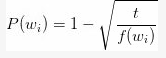其中 f(wi) 代表单词 wi 的出现频次。t为一个阈值，一般介于1e-3到1e-5之间。

In [5]:
import random
t = 1e-5
#求f(wi)
words_count = Counter(words)
total_count = len(set(words))
#计算单词的频率
words_freq = {word:freq/total_count for word,freq in words_count.items()}
#求P(wi)
#计算被删除的概率
words_temp = {word:(1-np.sqrt(t/freq)) for word,freq in words_freq.items()}
#删除
words_train = [word for word in words if random.random()<(1-words_temp[word])]


In [6]:
print(words_train[:5])

['culottes', 'vary', 'lacked', 'wealth', 'repudiated']


### 构造batch

skip_gram是有input_word来预测上下文，所以一个input_word会对应多个上下文。
我们来举个栗子“The quick brown fox jumps over lazy dog”，如果我们固定skip_window=2的话，那么fox的上下文就是[quick, brown, jumps, over]，如果我们的batch_size=1的话，那么实际上一个batch中有四个训练样本。
所以，首先要找到一个单词的上下文，然后基于上下文构建batch.

From Mikolov et al.:
"Since the more distant words are usually less related to the current word than those close to it, we give less weight to the distant words by sampling less from those words in our training examples... If we choose  C=5 , for each training word we will select randomly a number  R,R  in range  <1;C> , and then use  R words from history and  R  words from the future of the current word as correct labels."

In [7]:
def get_context(words,idx,window_size):
    """
    words:输入
    idx:input_word的索引
    window_size:窗口大小
    备注：python的切片不包含最右边的元素，例如a[1:3]返回a[1],a[2],而a[:3]返回前三个元素，a[0]a[1],a[2]
    第二点就是这里的上下文不包含input_word自身
    然后就是words[idx+1,end+1]这样会报错，list indices must be integers or slices, not tuple
    因为切片应该是words[idx+1:end+1]
    """
    target_window = np.random.randint(1,window_size+1)
    start = (idx - target_window ) if (idx - target_window > 0) else 0
    end = idx + target_window
    target_words = set(words[start:idx]+words[idx+1:end+1])
    return target_words

这里主要介绍一个batch_size,batch_size就是每一次送入网络训练的数据，这里batch_size=5，就是将words分成5个词为一组，对这一组中的每个词获取其上下文，例如['quick', 'brown','fox', 'jumps', 'over']，根据window_size对每个词构造上下文，然后组成一个多元组，假设对brown的时候根据window_size随机生成的target_size是3，则

x =  ['fox', 'fox', 'fox', 'fox']

y = [['quick', 'jumps', 'brown', 'over']]

而这一次根据这个batch生成的整个用于测试的batches可能如下：

x-[['quick'], ['brown', 'brown', 'brown', 'brown'], ['fox', 'fox', 'fox', 'fox'], ['jumps', 'jumps'], ['over', 'over', 'over']] 

y-[[['brown']], [['quick', 'jumps', 'fox', 'over']], [['quick', 'jumps', 'brown', 'over']], [['fox', 'over']], [['jumps', 'brown', 'fox']]]

In [15]:
#构建batch
def get_batches(words,batch_size,window_size):
    batch_num = len(words)//batch_size
    words = words[:batch_num*batch_size]
    
    for ii in range(0,len(words),batch_size):
        x,y=[],[]
        batch = words[ii:ii+batch_size] ##切记！！！！！！切片中间是:不是,
        for idx in range(len(batch)):
            batch_x = batch[idx]
            batch_y = get_context(batch,idx,window_size)
            x.append([batch_x]*len(batch_y))
            y.append([batch_y])
        yield x,y

## 第四部分  构造训练网络

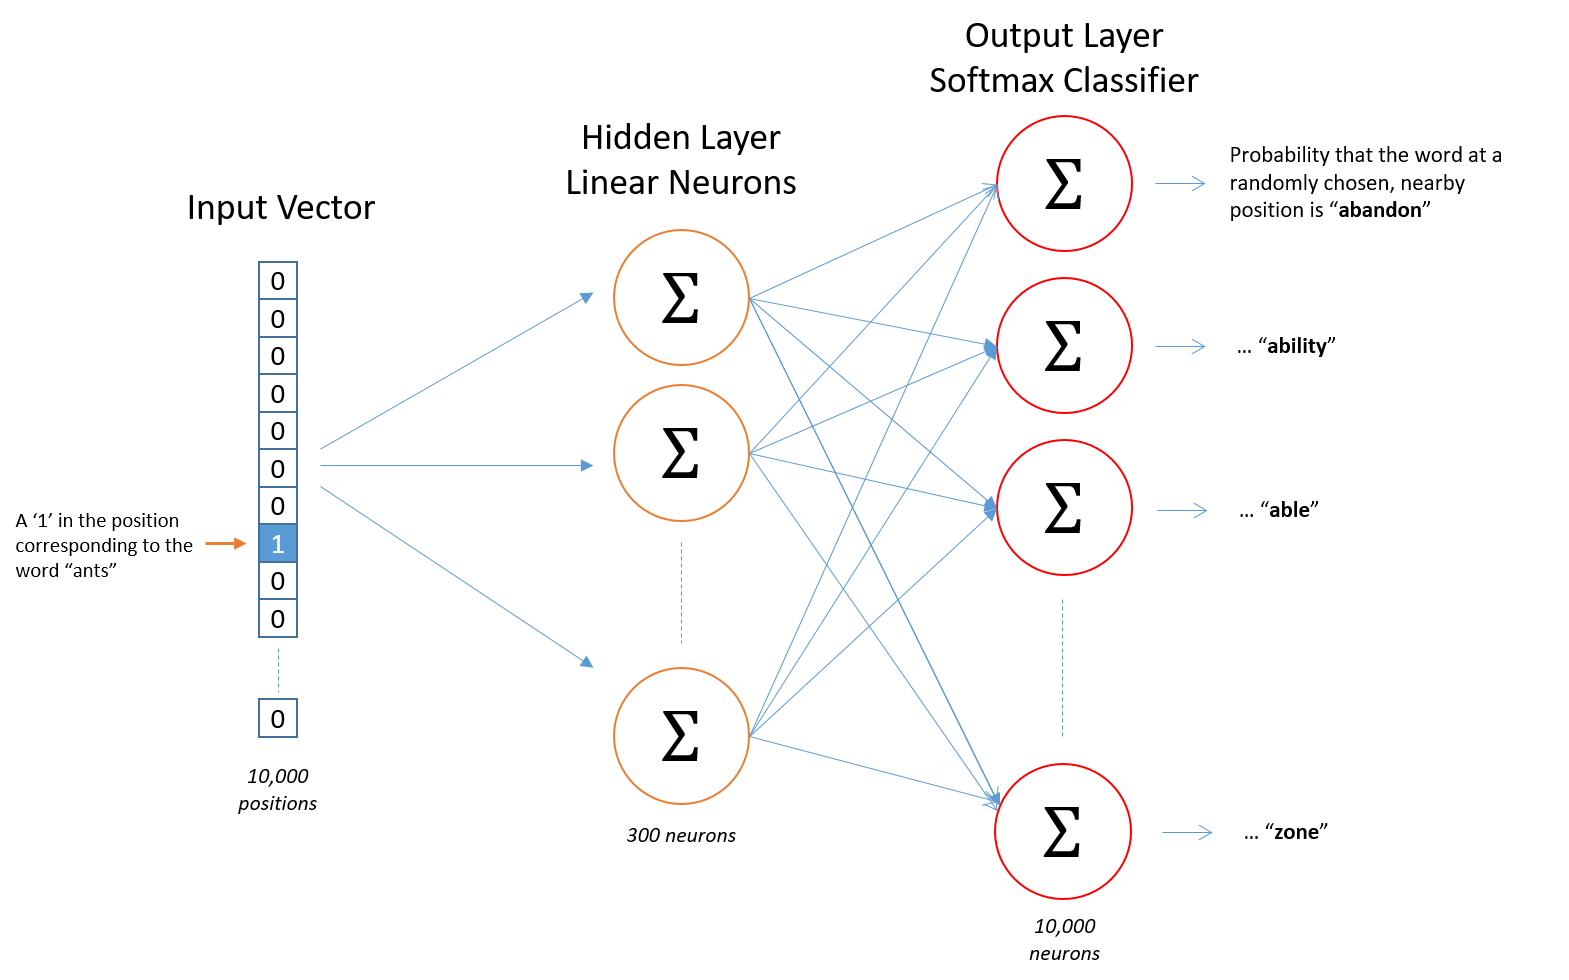

输入是一个one-hot，然后是一个linear的线性隐藏层，然后是一个softmax的输入层

### 输入层

In [9]:
train_graph = tf.Graph()
with train_graph.as_default():
    inputs_ = tf.placeholder(tf.int32,[None],name = 'inputs')
    labels_ = tf.placeholder(tf.int32,[None,None],name = 'labels')

### 隐藏层
隐藏层以上图为例，权重矩阵大小为10000*300,即字典大小*隐藏层的数目，然后为了节省计算，隐藏层的计算使用lookup查找方法。
input word和output word都会被我们进行one-hot编码。仔细想一下，我们的输入被one-hot编码以后大多数维度上都是0（实际上仅有一个位置为1），所以这个向量相当稀疏，那么会造成什么结果呢。如果我们将一个1 x 10000的向量和10000 x 300的矩阵相乘，它会消耗相当大的计算资源，为了高效计算，它仅仅会选择矩阵中对应的向量中维度值为1的索引行。
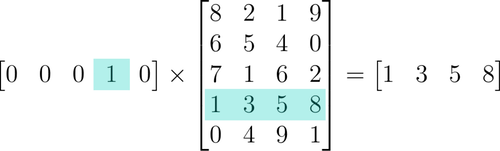

为了有效地进行计算，这种稀疏状态下不会进行矩阵乘法计算，可以看到矩阵的计算的结果实际上是矩阵对应的向量中值为1的索引，上面的例子中，左边向量中取值为1的对应维度为3（下标从0开始），那么计算结果就是矩阵的第3行（下标从0开始）—— [1，3，5，8]，这样模型中的隐层权重矩阵便成了一个”查找表“（lookup table），进行矩阵计算时，直接去查输入向量中取值为1的维度下对应的那些权重值。隐层的输出就是每个输入单词的“嵌入词向量”。
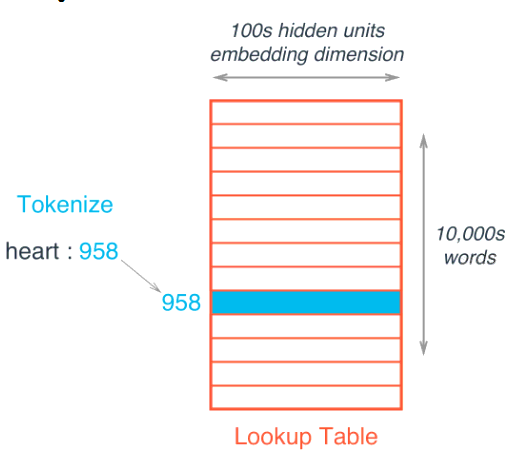

In [10]:
n_vocab = len(words_train)
n_embdding = 300 #一般取50-300
with train_graph.as_default():
    embdding = tf.Variable(tf.random_normal((n_vocab,n_embdding),-1,1),name='embdding')
    embed = tf.nn.embedding_lookup(embdding,inputs_)

### 输出层
使用negative-sampling,原因：在skip-gram中，每个input word的多个上下文单词实际上是共享一个权重矩阵，我们将每个（input word, output word）训练样本来作为我们的输入。为了加速训练并且提高词向量的质量，我们采用negative sampling的方法来进行权重更新。
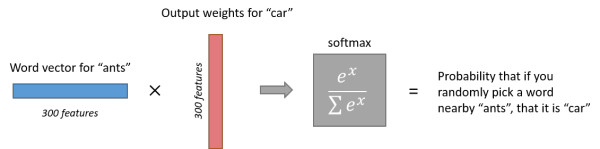

##### tf.nn.sampled_softmax_loss介绍
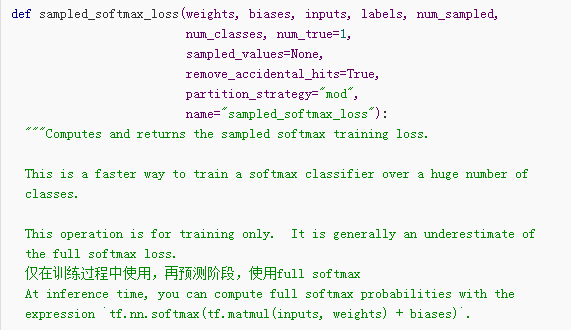

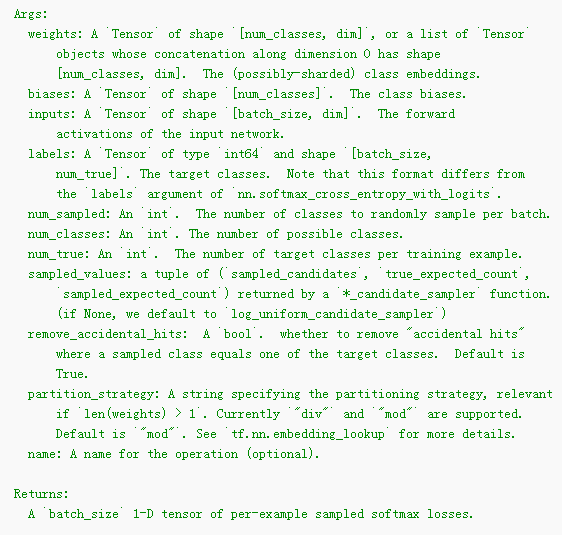

In [11]:
#number of negative labels to sample 
n_sample = 100
with train_graph.as_default():
    softmax_w = tf.Variable(tf.truncated_normal((n_vocab,n_embdding),stddev = 0.1))
    softmax_b = tf.Variable(tf.zeros(n_vocab))
    
    loss = tf.nn.sampled_softmax_loss(softmax_w,softmax_b,labels_,embed,n_sample,n_vocab)
    
    cost = tf.reduce_mean(loss)
    optimizer = tf.train.AdamOptimizer().minimize(cost)

### 模型验证

In [12]:
#创建验证集
with train_graph.as_default():
    valid_size = 16
    valid_window = 100
    # pick 8 samples from (0,100) and (1000,1100) each ranges. lower id implies more frequent
    valid_examples = np.array(random.sample(range(valid_window),valid_size//2))
    valid_examples = np.append(valid_examples,random.sample(range(1000,1000+valid_window),valid_size//2))
    
    valid_set = tf.constant(valid_examples,dtype=tf.int32)
     # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embdding),1,keep_dims=True))
    normalize_embedding = embdding/norm
    valid_embedding = tf.nn.embedding_lookup(normalize_embedding,valid_set)
    
    similarity =  tf.matmul(valid_embedding,tf.transpose(valid_embedding))
    

In [ ]:
# If the checkpoints directory doesn't exist:
!mkdir checkpoints

### 训练模型

In [ ]:
epoch = 20
batch_size = 100
window_size = 5

with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph = train_graph) as sess:
    iteration = 1
    loss = 0
    sess.run(tf.global_variables_initializer())
    
    for e in range(1,epoch+1):
        batches = get_batches(words_train,batch_size,window_size)
        start = time.time()
        for x,y in batches:
            feed = {inputs_:x,
                   labels_: np.array(y)[:, None]}
            train_loss,_ = sess.run([cost,optimizer],feed_dict = feed)
            print(train_loss)
            loss += train_loss
            
            if iteration%100==0:
                end = time.time()
                print("Epoch {}/{}".format(e, epochs),
                      "Iteration: {}".format(iteration),
                      "Avg. Training loss: {:.4f}".format(loss/100),
                      "{:.4f} sec/batch".format((end-start)/100))
                loss = 0
                start = time.time()
            if iteration % 1000 == 0:
                # note that this is expensive (~20% slowdown if computed every 500 steps)
                sim = similarity.eval()
                for i in range(valid_size):
                    valid_word = int_to_vocab[valid_examples[i]]
                    top_k = 8 # number of nearest neighbors
                    nearest = (-sim[i, :]).argsort()[1:top_k+1]
                    log = 'Nearest to %s:' % valid_word
                    for k in range(top_k):
                        close_word = int_to_vocab[nearest[k]]
                        log = '%s %s,' % (log, close_word)
                    print(log)
            iteration += 1
    save_path = saver.save(sess, "checkpoints/text8.ckpt")
    embed_mat = sess.run(normalized_embedding)